In [3]:
import os

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pydicom
# import SimpleITK as sitk

In [131]:
def show_img(img_path):
    img = nib.load(img_path)
    data = img.get_fdata()
    print(data.shape)
    # plt.imshow(data[:, :, data.shape[2] // 2], cmap='gray')
    plt.imshow(data[:, :, 23], cmap='gray')
    plt.show()

In [127]:
def load_dicom_series(directory):
    """ 读取DICOM序列并重新定向为RAI方向 """
    files = [pydicom.dcmread(os.path.join(directory, f)) for f in os.listdir(directory) if f.endswith('.dcm')]
    files.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    # 从 DICOM 文件中提取扫描数据
    # return np.stack([file.pixel_array for file in files],axis=-1)
    image_stack = np.stack([file.pixel_array for file in files], axis=-1)
    # RAS到RAI的转换，仅需要沿着Z轴翻转
    # image_stack = np.flip(image_stack, axis=0)
    image_stack = np.flip(image_stack, axis=1)
    # image_stack = np.flip(image_stack, axis=2)
    image_stack_rotated = np.rot90(image_stack, k=1, axes=(0, 1))

    # 获取体素间距
    pixel_spacing = files[0].PixelSpacing
    slice_thickness = abs(files[0].ImagePositionPatient[2] - files[1].ImagePositionPatient[2])

    return image_stack_rotated, (pixel_spacing[0], pixel_spacing[1], slice_thickness)


def convert_dicom_to_nifti(dicom_series, voxel_spacing, output_path):
    """ 将DICOM序列转换为NIfTI格式 """
    data = dicom_series.astype(np.int16)

    # 创建仿射矩阵
    affine = np.diag([voxel_spacing[0], voxel_spacing[1], voxel_spacing[2], 1])

    # img = nib.Nifti1Image(data, np.eye(4))
    img = nib.Nifti1Image(data, affine)
    nib.save(img, output_path)

In [128]:
# 用你的DICOM序列目录和输出文件路径替换这些
dicom_directory = '/Users/zhutaonan/Downloads/data1207/复发验证集-V120/00197027V/'
nifti_output_path = '../00197027.nii.gz'

# 加载DICOM序列并转换
dicom_series, voxel_spacing = load_dicom_series(dicom_directory)
convert_dicom_to_nifti(dicom_series, voxel_spacing, nifti_output_path)

# import dicom2nifti
# dicom2nifti.convert_directory(dicom_directory,"../")

(512, 512, 38)


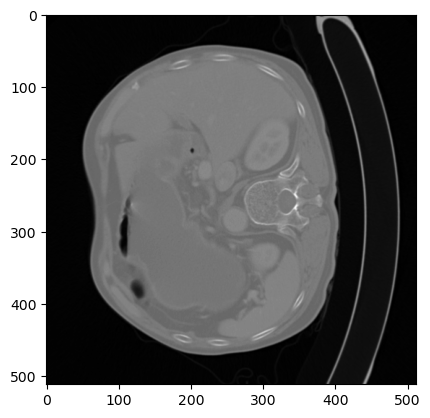

In [132]:
# show_img("../data/data1207/origin_data/00189740V.nii.gz")
show_img("../00197027.nii.gz")

(512, 512, 31)


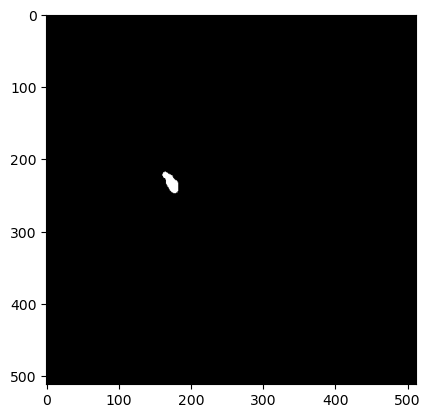

In [114]:
show_img("../data/data1207/roi_data/00189740_Merge.nii.gz")

(512, 512, 56)


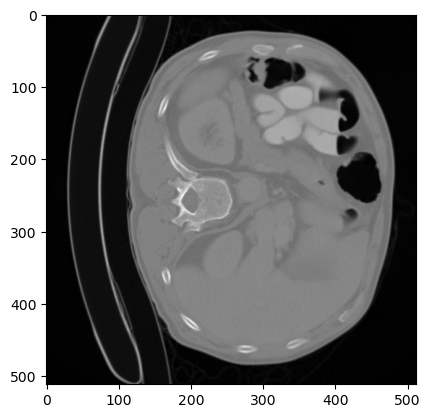

In [112]:
show_img("../data/Task09_Spleen/imagesTr/spleen_31.nii.gz")

(512, 512, 56)


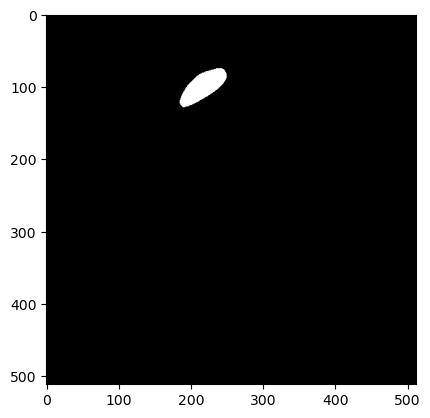

In [113]:
show_img("../data/Task09_Spleen/labelsTr/spleen_31.nii.gz")

In [120]:
def convert_rai_to_lpi(input_file, output_file):
    # Load the image
    img = nib.load(input_file)
    data = img.get_fdata()

    # RAI to LPI conversion:
    # - R to L: Flip along the X-axis
    # - A to P: Flip along the Y-axis
    # No change needed for I to I
    converted_data = np.flip(data, (0, 1))

    new_affine = img.affine.copy()
    new_affine[0, :] *= -1  # Flip X-axis
    new_affine[1, :] *= -1  # Flip Y-axis

    # Create a new Nifti1Image with the converted data
    converted_img = nib.Nifti1Image(converted_data, new_affine)

    # Save the converted image
    nib.save(converted_img, output_file)


In [121]:
input_file = '../data/data1207/roi_data/00189740_Merge.nii.gz'
output_file = '../00189740_Merge_lpi.nii.gz'
convert_rai_to_lpi(input_file, output_file)

In [8]:
def get_orientation_from_affine(affine):
    # Define the standard axis directions in RAS space
    axis_directions = {
        0: ('R', 'L'),
        1: ('A', 'P'),
        2: ('S', 'I')
    }
    orientation = ""

    # For each axis in the affine matrix, determine the direction
    for i in range(3):
        axis = affine[i, :3]
        direction = axis_directions[i][0] if axis[i] > 0 else axis_directions[i][1]
        orientation += direction

    return orientation


def get_image_orientation(nii_file):
    # Load the image
    img = nib.load(nii_file)
    # The affine matrix
    affine = img.affine
    # Get orientation
    # print(affine)
    return get_orientation_from_affine(affine)


# print(get_image_orientation(output_file))
print(get_image_orientation("../data/Task09_Spleen/imagesTr/spleen_31.nii.gz"))
print(get_image_orientation("../data/Task09_Spleen/labelsTr/spleen_31.nii.gz"))

RAS
RAS


In [9]:
print(get_image_orientation("../data/data1207/roi_data/00189740_Merge.nii.gz"))
print(get_image_orientation("../data/data1207/origin_data/00189740V.nii.gz"))
print(get_image_orientation("../data/Task09_Spleen/imagesTr/spleen_2.nii.gz"))
print(get_image_orientation("../00197027.nii.gz"))

LPS
RAS
RAS
LPS


In [2]:
def get_voxel_spacing(image_path):
    # 加载NIfTI文件
    nifti_img = nib.load(image_path)
    # 体素间距
    voxel_spacing = nifti_img.header.get_zooms()
    return voxel_spacing

In [7]:
print(get_voxel_spacing("../data/data1207/roi_data/00189740_Merge.nii.gz"))
print(get_voxel_spacing("../data/data1207/origin_data/00189740V.nii.gz"))
print(get_voxel_spacing("../data/Task09_Spleen/imagesTr/spleen_2.nii.gz"))
print(get_voxel_spacing("../00197027.nii.gz"))
print(get_voxel_spacing("/Users/zhutaonan/Library/Containers/com.tencent.xinWeChat/Data/Library/Application Support/com.tencent.xinWeChat/2.0b4.0.9/5ceade320df788a8c0b9a221edaaa3ad/Message/MessageTemp/8ca9f2af067f7a465e92d8f556540523/OpenData/1234.nii.gz"))

(0.59765625, 0.59765625, 6.0)
(1.0, 1.0, 1.0)
(0.794922, 0.794922, 5.0)
(0.6855469, 0.6855469, 6.0)
(0.59765625, 0.59765625, 6.0)


In [135]:
import itk
import os

def convert_dicom_to_nifti(dicom_directory, output_directory):
    # 读取 DICOM 图像
    reader = itk.ImageSeriesReader.New()
    dicom_io = itk.GDCMImageIO.New()
    reader.SetImageIO(dicom_io)

    # 获取 DICOM 文件列表
    names_generator = itk.GDCMSeriesFileNames.New()
    names_generator.SetDirectory(dicom_directory)
    series_uids = names_generator.GetSeriesUIDs()

    # 遍历每个系列
    for uid in series_uids:
        file_names = names_generator.GetFileNames(uid)
        reader.SetFileNames(file_names)

        # 读取图像
        image = reader.Execute()

        # 构造输出文件名
        output_file = os.path.join(output_directory, uid + ".nii.gz")

        # 写入 NIfTI 图像
        itk.imwrite(image, output_file)
        print(f"Converted DICOM series {uid} to {output_file}")

# 调用函数
convert_dicom_to_nifti("/Users/zhutaonan/Downloads/data1207/复发验证集-V120/00197027V/", "../")

AttributeError: module 'itk' has no attribute 'ImageSeriesReader'

In [6]:
import SimpleITK as sitk

# 读取DICOM图像
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('/Users/zhutaonan/Downloads/data1207/复发验证集-V120/00197027V/')
reader.SetFileNames(dicom_names)
image = reader.Execute()

# 将图像保存为NIfTI格式
sitk.WriteImage(image,"../00197027.nii.gz")

In [11]:
# 加载两个 NIfTI 文件
nifti_file1 = nib.load('../data/data1207/roi_data/00197027_Merge.nii.gz')
nifti_file2 = nib.load('../00197027.nii.gz')

# 获取头文件信息
header1 = nifti_file1.header
header2 = nifti_file2.header

# 比较重要的头文件字段
print("Header comparison:")
print("Dimensions:", header1['dim'], header2['dim'])
print("Voxel Size (pixdim):", header1['pixdim'], header2['pixdim'])
print("Data Type:", header1['datatype'], header2['datatype'])
print("Voxel Offset:", header1['vox_offset'], header2['vox_offset'])
print("Orientation and Origin:", header1.get_best_affine(), header2.get_best_affine())

Header comparison:
Dimensions: [  3 512 512  38   1   1   1   1] [  3 512 512  38   1   1   1   1]
Voxel Size (pixdim): [1.        0.6855469 0.6855469 6.        0.        0.        0.
 0.       ] [1.        0.6855469 0.6855469 6.        0.        0.        0.
 0.       ]
Data Type: 512 4
Voxel Offset: 0.0 0.0
Orientation and Origin: [[-6.85546875e-01  0.00000000e+00  0.00000000e+00  1.91157227e+02]
 [ 0.00000000e+00 -6.85546875e-01  0.00000000e+00  3.06157227e+02]
 [ 0.00000000e+00  0.00000000e+00  6.00000000e+00 -6.92500000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-6.85546875e-01  0.00000000e+00  0.00000000e+00  1.91157227e+02]
 [ 0.00000000e+00 -6.85546875e-01  0.00000000e+00  3.06157227e+02]
 [ 0.00000000e+00  0.00000000e+00  6.00000000e+00 -6.92500000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
